In [1]:
import sys
sys.path.insert(0, '../src')

from megs.model.mPCA import mPCA
from megs.data import image, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_context("paper")
#Load Data
data = DataLoader("/export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5")

norm = image.norm
lower = 0.25
upper = 1.0
norm_function_args = {"Masses": {"takelog": True, "plusone": True,"lower": lower, "upper": upper},
                     "GFM_Metallicity": {"takelog": True, "plusone": True, "lower": 0.1, "upper": upper},
                     "GFM_StellarFormationTime": {"takelog": True, "plusone": True, "lower": 0.1, "upper": upper},
                    
}

# Define Model
mm = mPCA(data, norm_function = norm, norm_function_kwargs=norm_function_args, dim = 2)

# Train Model
mm.fit(n_components=60, show_results = False)

File: /export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5
Group: Galaxies
    Group: Attributes
        Dataset: halo_id (float32) ((12484,))
        Dataset: mass (float32) ((12484,))
    Group: Particles
        Group: stars
            Group: Images
                Group: dim2
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64))
                Group: dim3
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64, 64))
Creating datamatrix with the following fields:
Particle type:  stars
Fields:  ['GFM_Metallicity', 'GFM_StellarFormationTime', 'Masses']
Dimension:  dim2
Default arguments are used for the fields that are not specified in the norm_fu

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import trange
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [120]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, layer_size_1, latent_size =60, hidden_layers = 5, activation_function=nn.ReLU(),
                 dropout_rate = 0.5):
        super(Net, self).__init__()
        # Define the layers of your neural network
        self.fc1 = nn.Linear(layer_size_1, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.linear_128_128= nn.Linear(128, 128)
        self.final = nn.Linear(128, latent_size)  # 60 output nodes for PCA scores
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer for regularization
        self.act = activation_function
        linear_layers = []
        self.hidden_layers = hidden_layers
        for i in range(hidden_layers):
            linear_layers.append(nn.Linear(128, 128))
        self.linear_layers = nn.ModuleList(linear_layers)
            
        

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.act(self.fc1(x))
        x = self.dropout(x)
        x = self.act(self.fc2(x))
        x = self.dropout(x)
        x = self.act(self.fc3(x))
        x = self.dropout(x)
        for i in range(self.hidden_layers):
            x = self.act(self.linear_layers[i](x))
            x = self.dropout(x)
        x = self.final(x)
        return x


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Linear(64*16*16, 60)

    def forward(self, x):
        out = self.conv(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
    
    
class GalaxyCNN(nn.Module):
    def __init__(self, latent_dim=60, img_channels=1,activation_function=nn.ReLU()):
        super(GalaxyCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(img_channels, 32, kernel_size=4, stride=2, padding=1),  # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 32 -> 16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16 -> 8
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 8 -> 4
            nn.ReLU(),
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            activation_function,
            nn.Linear(1024, latent_dim),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = self.fc_layers(x)
        return x
    
    
class Decoder(nn.Module):
    def __init__(self, eigengalaxies, means, num_fields = 3, img_size = 64):
        super(Decoder, self).__init__()
        self.eigengalaxies = eigengalaxies.view(eigengalaxies.size(0), num_fields * 64**2)
        self.means = means.view(num_fields *64**2)

    def forward(self, x):
        # Assumes x is of shape (batch_size, eigengalaxies.size(0))
        x = x @ self.eigengalaxies + self.means  # Linear combination
        # Reshapes the output back to the original image shape
        x = x.view(x.size(0), 3, 64, 64)
        return x


In [124]:


# Step 3: Split the dataset into training and testing sets

# Step 4: Train the neural network




num_epochs = 1000

data = mm.datamatrix.reshape(12484, 3, 64, 64)
# data = data[:, 0, :]  # Use only the first map to learn the scores
targets = mm.scores

# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.2, random_state=42)

# Assuming you have your training data and targets as tensors
train_data = torch.Tensor(train_data).to(device)
train_targets = torch.Tensor(train_targets).to(device)

test_data = torch.Tensor(test_data).to(device)
test_targets = torch.Tensor(test_targets).to(device)

# Convert test data and targets into a TensorDataset

# Convert training data and targets into a TensorDataset
train_dataset = TensorDataset(train_data, train_targets)
test_dataset = TensorDataset(test_data, test_targets)
# Define the batch size for training
batch_size = 64



# Create the train_loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

train_loss = []
test_loss = []




img_size = 64 * 64  # Number of pixels in each image
# model = Net(layer_size_1=img_size,latent_size=60,hidden_layers=10,activation_function=nn.Tanh(), dropout_rate=0.2).to(device)
model = GalaxyCNN(latent_dim=60, img_channels=1, activation_function= nn.Sigmoid()).to(device)

eigen = torch.Tensor(mm.eigengalaxies).to(device)
means = torch.Tensor(mm.get_means()).to(device)
decoder = Decoder(eigen, means)

criterion = nn.MSELoss().to(device)  # Use mean squared error as the loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Add weight decay for regularization


In [122]:
def show(predicted_score, target_score, savepath):
    reconstructed_images_pred = mm.reconstruct(predicted_score)
    reconstructed_images_target = mm.reconstruct(target_score)
    # Make residual plots for all 3 maps
    # Calculate residuals for each map
    residuals = np.abs(reconstructed_images_pred - reconstructed_images_target) / reconstructed_images_target * 100

    reconstruction_error = np.median(residuals)
    # Plot the original images, reconstructed images, and residuals
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    # Iterate over the maps
    for i in range(3):
        # Plot original image
        axes[i, 0].imshow(reconstructed_images_target[i])
        axes[i, 0].set_title(f"Ground Truth Map {i+1}")
        # Plot reconstructed image from predicted scores
        axes[i, 1].imshow(reconstructed_images_pred[i])
        axes[i, 1].set_title(f"Reconstructed (Predicted) Map {i+1}")

        axes[i,2].imshow(residuals[i], cmap = "coolwarm",vmin=-100, vmax=100)
        axes[i, 2].set_title(f"Residual {i+1}")
        # Set axis labels
        for j in range(3):
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.savefig(savepath)
    plt.close("all")


In [125]:

log_file = "loss_log.txt"
# Create a new file for logging
with open(log_file, "w") as f:
    f.write("")
# Start training

lambda_scores_loss = 0.2
lambda_reconstruction_loss = 0.8



def loss_func(scores, targets, inputs, decoder):
    scores_loss = criterion(scores, targets)
    reconstructed = decoder(scores)
    reconstruction_loss = criterion(reconstructed, inputs)
    
    return lambda_scores_loss*scores_loss+lambda_reconstruction_loss*reconstruction_loss


for epoch in trange(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:  # Iterate over the training set
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        input_img = inputs[:, 0, :]
        input_img = input_img.view(-1, 1, 64, 64)
        outputs = model(input_img) # Scores: (batch_size, 60)
        loss = loss_func(outputs, targets, inputs, decoder)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    average_loss = running_loss / len(train_loader)
    train_loss.append(average_loss)
    if epoch % 10 == 0:
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}\n")

        
     
    # Periodically compute and print the mean train and test loss
    if epoch % 10 == 0:
        test_loss_this_epoch = []

        # Set the model to evaluation mode
        model.eval()

        # Disable gradient calculation
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                input_img = inputs[:, 0, :]
                input_img = input_img.view(-1, 1, 64, 64)
                outputs = model(input_img) # Scores: (batch_size, 60)
                # loss = criterion(outputs, targets)
                loss = loss_func(outputs, targets, inputs, decoder)
                test_loss_this_epoch.append(loss.item())
            show(outputs[0].detach().cpu().numpy(), targets[0].detach().cpu().numpy(), savepath=f"epochs/epoch_{epoch}.png")
            

        model.train()  # Set the model back to training mode

        test_loss_mean = torch.mean(torch.Tensor(test_loss_this_epoch)).item()
        test_loss.append(test_loss_mean)

        with open(log_file, "a") as f:
            f.write(f"Mean Test Loss: {test_loss[-1]:.2e}\n")

# Step 5: Evaluate the trained model
# Compute predicted PCA components for the testing set
# Compare predicted components with ground truth and calculate evaluation metrics


 14%|█▍        | 145/1000 [03:26<20:12,  1.42s/it]

In [105]:
def evaluate(model, test_data, test_targets, batch_size=64):
    # Put the model in evaluation mode
    model.eval()

    # Create tensors for the test data
    test_data = torch.Tensor(test_data).to(device)
    test_targets = torch.Tensor(test_targets).to(device)

    # Create a test dataset
    test_dataset = TensorDataset(test_data, test_targets)

    # Create a test data loader
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Lists to store predicted PCA components
    predicted_scores = []

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, targets in test_loader:
            # Move inputs to the GPU device
            inputs = inputs.to(device)
            inputs = inputs.view(-1, 1, 64, 64)
            # Forward pass
            outputs = model(inputs)

            # Move outputs back to the CPU
            outputs = outputs.cpu().numpy()

            predicted_scores.append(outputs)

    # Concatenate predicted PCA components
    predscores = np.concatenate(predicted_scores)
    return predscores
def evaluate_prediction(predicted_score, target_score, index,plot = True):
    target_score= target_score.cpu().numpy()
    
    predicted_score = predicted_score[index]
    target_score = target_score[index]
    
    reconstructed_images_pred = mm.reconstruct(predicted_score)
    reconstructed_images_target = mm.reconstruct(target_score)
    # Make residual plots for all 3 maps
    # Calculate residuals for each map
    residuals = np.abs(reconstructed_images_pred - reconstructed_images_target) / reconstructed_images_target * 100

    reconstruction_error = np.median(residuals)
    if not plot: return reconstruction_error
    # Plot the original images, reconstructed images, and residuals
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    # Iterate over the maps
    for i in range(3):
        # Plot original image
        axes[i, 0].imshow(reconstructed_images_target[i])
        axes[i, 0].set_title(f"Ground Truth Map {i+1}")
        # Plot reconstructed image from predicted scores
        axes[i, 1].imshow(reconstructed_images_pred[i])
        axes[i, 1].set_title(f"Reconstructed (Predicted) Map {i+1}")

        axes[i,2].imshow(residuals[i], cmap = "coolwarm",vmin=-100, vmax=100)
        axes[i, 2].set_title(f"Residual {i+1}")

        
        

        # Set axis labels
        for j in range(3):
            axes[i, j].axis("off")

    plt.tight_layout()
    plt.show()
    return reconstruction_error

def continue_training(model, num_epochs):
    with open(log_file, "a") as f:
        f.write(f"------------Continuing training for {num_epochs} epochs----------------\n")
    model.train()
    for epoch in trange(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:  # Iterate over the training set
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        average_loss = running_loss / len(train_loader)
        train_loss.append(average_loss)
        if epoch % 80 == 0:
            with open(log_file, "a") as f:
                f.write(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}\n")

        # Periodically compute and print the mean train and test loss
        if epoch % 10 == 0:
            test_loss_this_epoch = []

            # Set the model to evaluation mode
            model.eval()

            # Disable gradient calculation
            with torch.no_grad():
                for inputs, targets in test_loader:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    test_loss_this_epoch.append(loss.item())

            model.train()  # Set the model back to training mode

            test_loss_mean = torch.mean(torch.Tensor(test_loss_this_epoch)).item()
            test_loss.append(test_loss_mean)

            with open(log_file, "a") as f:
                f.write(f"Mean Test Loss: {test_loss[-1]:.2e}\n")

    plt.plot(range(len(train_loss)), train_loss, label='Train Loss')
    plt.plot(range(10, num_epochs + 1, 10), test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

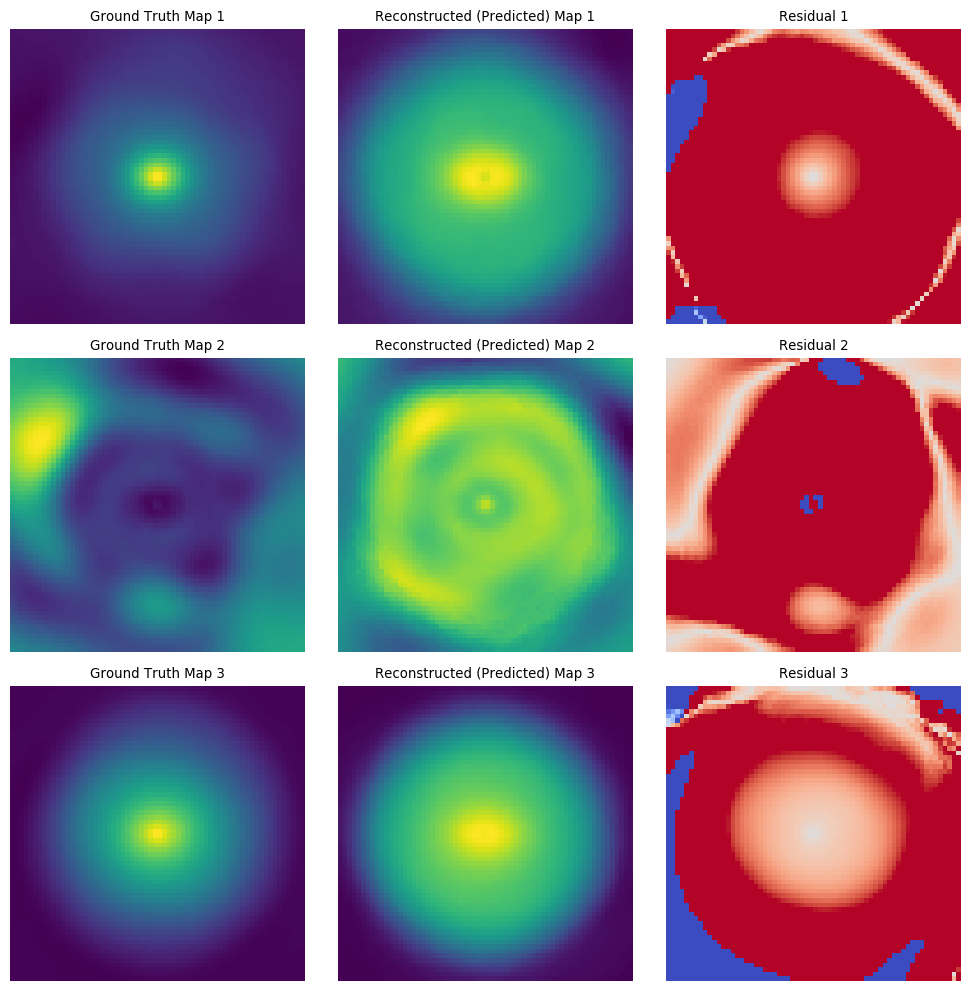

150.48378006469784

In [119]:
evaluate_prediction(scores, test_targets, 8)

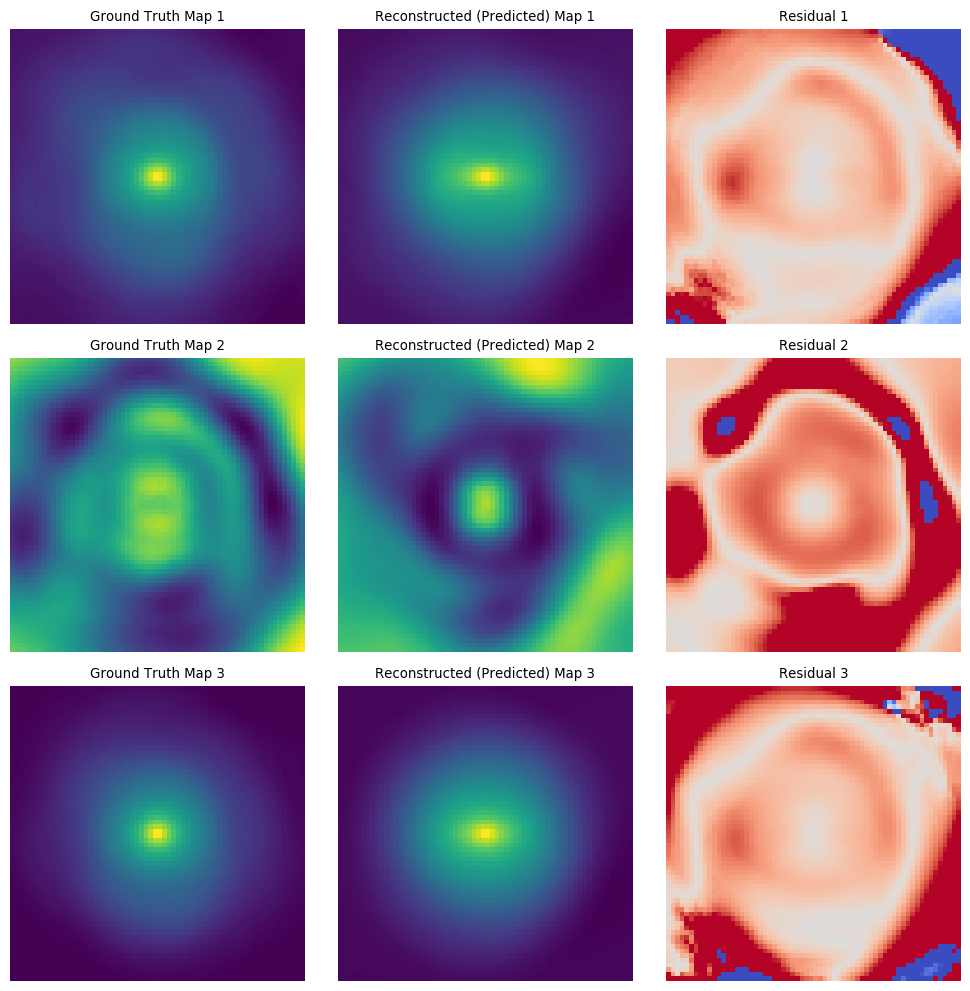

35.96376246484422

In [110]:
scores = evaluate(model, test_data, test_targets)
evaluate_prediction(scores, test_targets, index = 20)

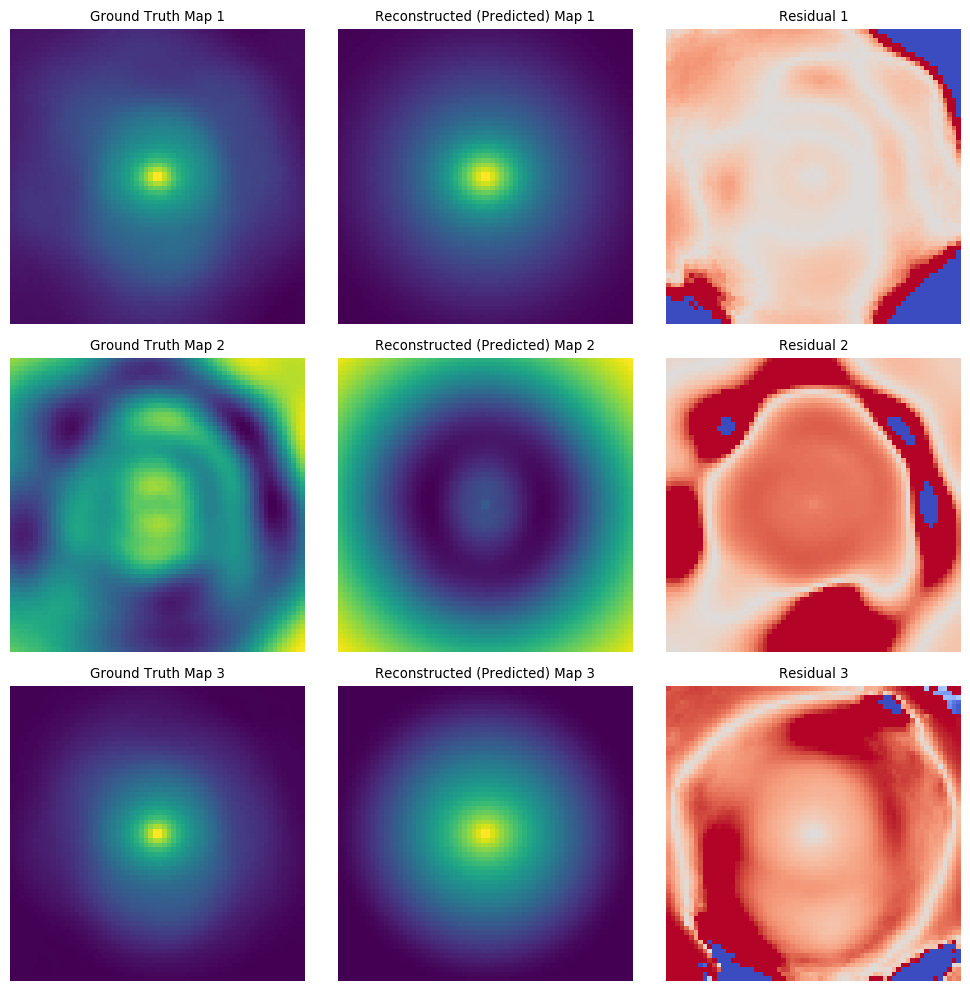

40.74029292714629

In [28]:
scores = evaluate(model, test_data, test_targets)
evaluate_prediction(scores, test_targets, index = 20)

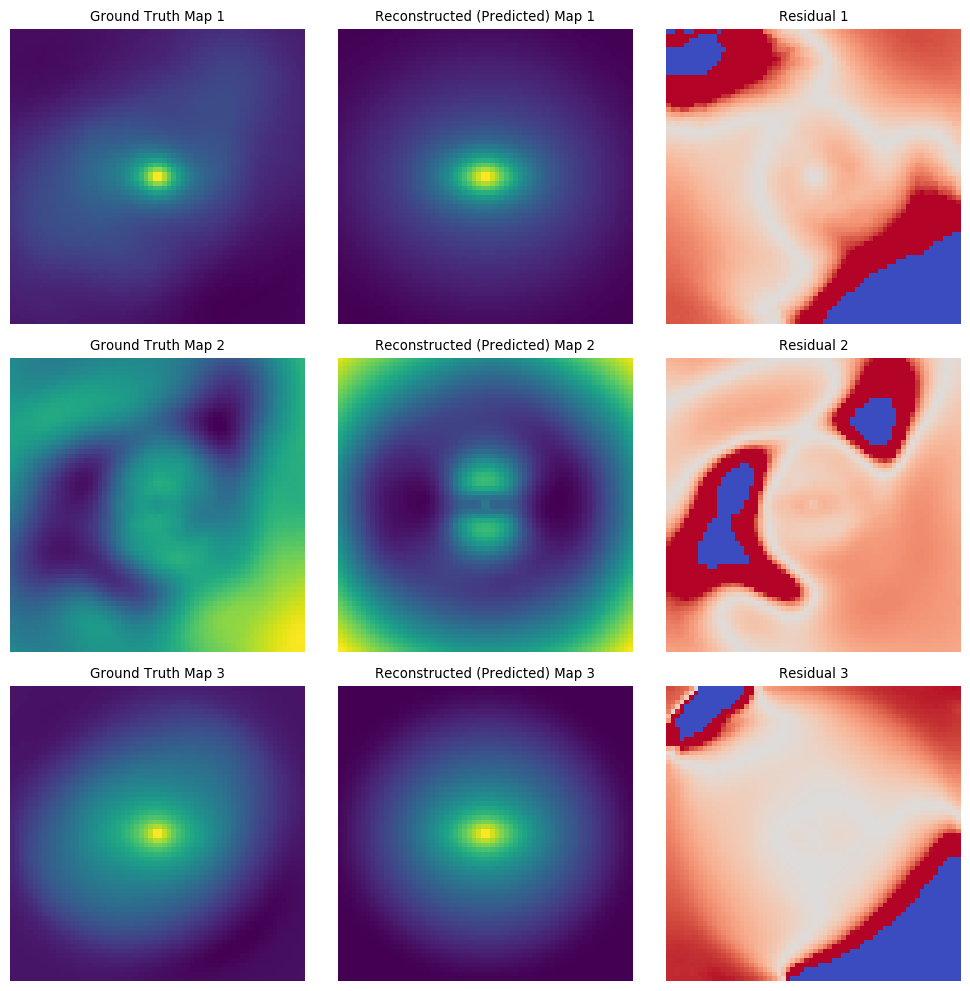

29.063249182826254

100%|██████████| 2000/2000 [18:41<00:00,  1.78it/s]


ValueError: x and y must have same first dimension, but have shapes (200,) and (300,)

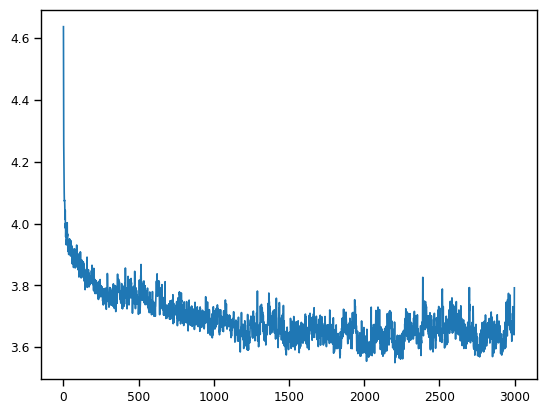

In [26]:
continue_training(model, 2000)

In [51]:
rec_errors = [evaluate_prediction(predscores[index], test_targets[index].cpu(), plot=False) for index in range(test_targets.shape[0])]

(array([  3.,  11.,  17.,  53.,  73.,  84., 110., 105., 154., 142., 128.,
        140., 146., 144., 131., 109., 103.,  84.,  99.,  74.,  69.,  52.,
         45.,  52.,  49.,  32.,  40.,  24.,  25.,  26.,  18.,  24.,  15.,
         16.,   6.,  11.,   4.,   3.,  11.,   8.,   5.,   4.,   4.,   4.,
          3.,   7.,   5.,   5.,   2.,   1.,   0.,   1.,   0.,   1.,   1.,
          0.,   2.,   0.,   1.,   1.,   1.,   0.,   1.,   2.,   1.,   1.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  5.7944955 ,   6.81220832,   7.82992114,   8.84763396,
          9.86534678,  10.88305961,  11.90077243,  12.91848525,
         13.93619807,  14.95391089,  15.97162371,  16.98933653,
         18.00704935,  19.02476217,  20.04247499,  21.06018781,
         22.07790063,  23.09561345,  24.11332627,  25.13103909

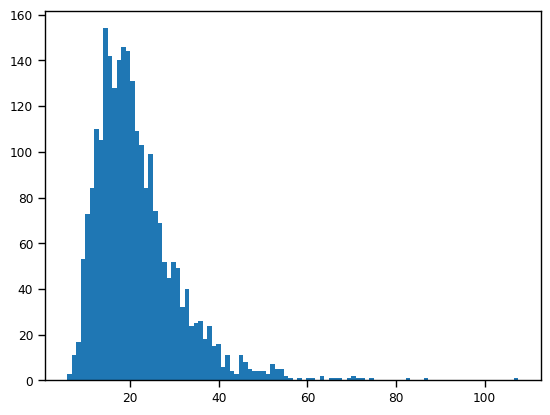

In [52]:
plt.hist(rec_errors, bins = 100)

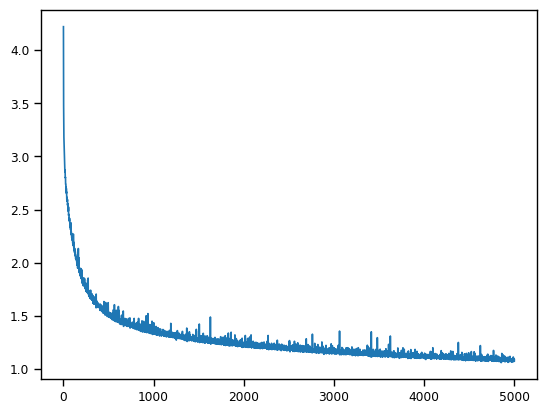

In [53]:
plt.plot(np.arange(len(train_loss)), train_loss)

In [58]:
torch.save(model.state_dict(), 'new_model_snapshot.pth')